In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd

In [2]:
adata = sc.read("../Input_file-PAGA/Pseudotime_input.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 15933 × 24641
    obs: 'cell_type', 'sample'
    obsm: 'X_umap'

In [4]:
adata.obs

,cell_type,sample
AAACGAATCAAGTGGG-1_1,LC_ER-_LuP,CTL
AAAGAACTCTAAACGC-1_1,Myo,CTL
AAAGGGCTCTGTCAGA-1_1,LC_ER-_LuP,CTL
AAAGTCCAGTGCTCGC-1_1,LC_ER+_Foxa1,CTL
AAAGTCCCACTGGACC-1_1,LC_ER-_LuP,CTL
...,...,...
TTTGTTGCATCGAAGG-1_3,LC_ER+_Sca1,ER_Pik
TTTGTTGGTTAGAGTA-1_3,Late_HY,ER_Pik
TTTGTTGTCCTTCTGG-1_3,Late_HY,ER_Pik
TTTGTTGTCGCAAGAG-1_3,LC_ER+_Foxa1,ER_Pik


In [5]:
# PCA
sc.pp.pca(adata, n_comps=50)

In [6]:
adata_sub = adata[adata.obs["sample"] == "ER_Pik"].copy()

In [7]:
# Compute neighborhood graph
sc.pp.neighbors(adata_sub, n_neighbors=15, n_pcs=50)

In [8]:
sc.tl.paga(adata_sub, groups='cell_type')

In [9]:
# 1) Compute diffusion map (DPT depends on it)
sc.tl.diffmap(adata_sub)

In [10]:
# 2) Pick a root cell (string id) – e.g. any cell from your start cluster
root_group = "LC_ER+_Sca1"
root_cell = adata_sub.obs_names[adata_sub.obs["cell_type"] == root_group][0]

In [11]:
# 3) Set iroot (integer index of the root cell)
import numpy as np
adata_sub.uns['iroot'] = np.where(adata_sub.obs_names == root_cell)[0][0]

In [12]:
# 4) Run DPT
sc.tl.dpt(adata_sub, n_dcs=10)   # pseudotime in adata_sub.obs['dpt_pseudotime']

In [13]:
# Orient toward a desired “end” cluster

end_group = "Myo"
pt = adata_sub.obs["dpt_pseudotime"].astype(float).copy()

if pt[adata_sub.obs["cell_type"] == end_group].mean() < pt[adata_sub.obs["cell_type"] == root_group].mean():
    pt = 1.0 - pt

pt = (pt - np.nanmin(pt)) / (np.nanmax(pt) - np.nanmin(pt) + 1e-12)
adata_sub.obs["pt_oriented"] = pt

<Axes:>

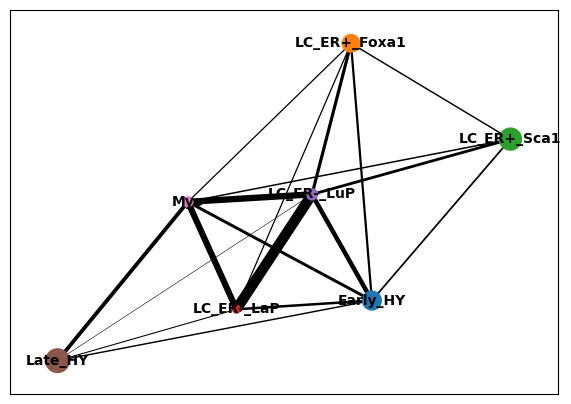

In [14]:
sc.pl.paga(adata_sub, color=['cell_type'], threshold=0.03, show=False)

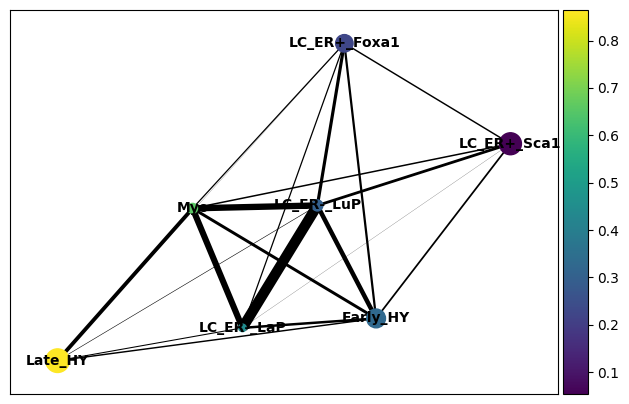

In [15]:
sc.pl.paga(adata_sub, color=["pt_oriented"], save="_ERPik.pdf")

In [16]:
sc.tl.draw_graph(adata_sub, init_pos="paga")

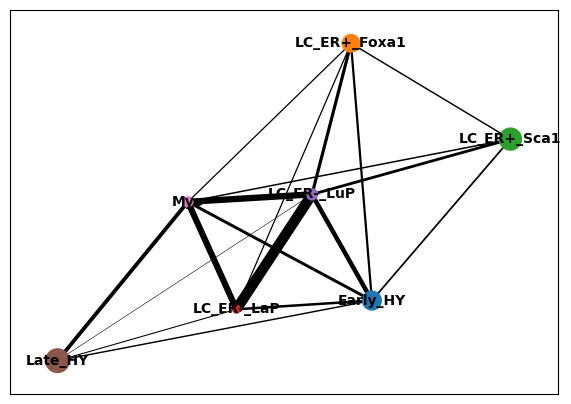

In [17]:
sc.pl.paga(adata_sub, color=["cell_type"], threshold=0.03)

In [18]:
import matplotlib.pyplot as pl

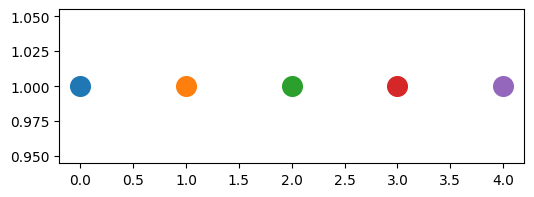

In [19]:
pl.figure(figsize=(6, 2))

for i in range(5):
    pl.scatter(i, 1, s=200)

pl.show()

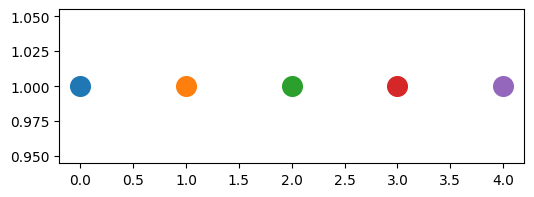

In [20]:
pl.figure(figsize=(6, 2))

for i in range(5):
    pl.scatter(i, 1, s=200)

pl.savefig('PAGA_order_ERPik.pdf', format='pdf')
    
pl.show()


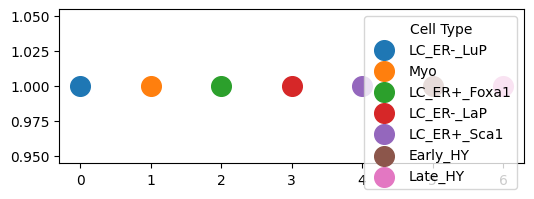

In [21]:
# Create a new plot and add scatter points with your annotations
fig, ax = pl.subplots(figsize=(6, 2))

# Plot using the annotations in adata.obs['cell_type'] as labels for the legend
for i, label in enumerate(adata.obs['cell_type'].unique()):
    ax.scatter(i, 1, s=200, label=label)

# Add the legend
ax.legend(title="Cell Type")

pl.savefig('PAGA_order_ERPik_Legend.pdf', format='pdf')

# Show the plot
pl.show()

<Axes:ylabel='pt_oriented'>

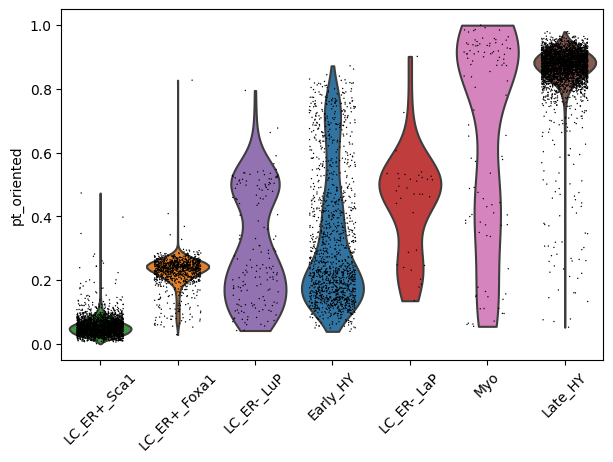

In [22]:
# Present pseudotime calculated by PAGA?

# (Optional) order clusters by mean pt_oriented
order = (
    adata_sub.obs.groupby("cell_type")["pt_oriented"]
    .mean()
    .sort_values()
    .index
)
sc.pl.violin(
    adata_sub,
    keys="pt_oriented",
    groupby="cell_type",
    order=order,
    stripplot=True,  # add points
    jitter=0.3,
    rotation=45,
    save=None,       # set e.g. save="_pt_violin.pdf" to auto-save
    show=False
)

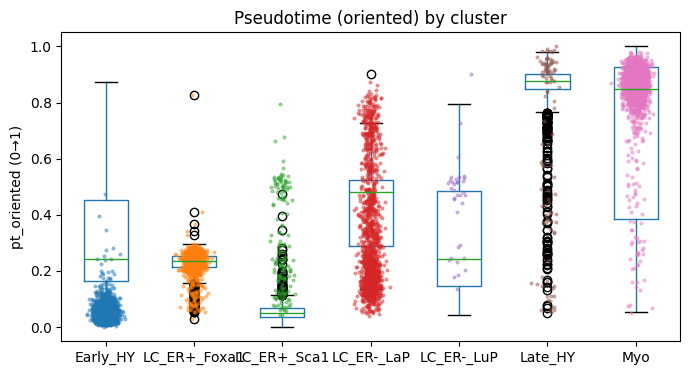

In [24]:
import matplotlib.pyplot as plt

df = adata_sub.obs[["cell_type", "pt_oriented"]].dropna().copy()
order = df.groupby("cell_type")["pt_oriented"].mean().sort_values().index

fig, ax = plt.subplots(figsize=(7,4))
# boxplot
df["cell_type"] = pd.Categorical(df["cell_type"], categories=order, ordered=True)
df.boxplot(column="pt_oriented", by="cell_type", ax=ax, grid=False)

# jittered points
for i, ct in enumerate(order, start=1):
    y = df.loc[df["cell_type"] == ct, "pt_oriented"].values
    x = np.random.normal(loc=i, scale=0.06, size=len(y))
    ax.plot(x, y, "o", ms=2, alpha=0.4)

ax.set_title("Pseudotime (oriented) by cluster")
ax.set_xlabel("")
ax.set_ylabel("pt_oriented (0→1)")
plt.suptitle("")
plt.tight_layout()